# STA 141B: Homework 5
## Wei-Kuang  (Jerry) Lin 

# Housing data

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

In [28]:
# Data Frame and array operation
import pandas as pd
import numpy as np

# Geography operation
import geopandas as gpd           # conda install -c conda-forge geopandas
import osmnx as ox                # conda install -c conda-forge osmnx
import shapely.geometry as geom   # conda install -c conda-forge shapely

# SQL
import sqlalchemy as sqla         # a nice “Pythonic” way of interacting with SQL databases
                                  # Discussion-07 provides info to use SQL in python
                                  # Prof. Sharpnack's Lesson_13_Notebook : SQL with Pandas

# Data visualization
%matplotlib inline                
import matplotlib.pyplot as plt
plt.style.use('ggplot')           # This adjusts the plotting style to emulate ggplot's aesthetic design.
import seaborn as sns

# Exercise 1:  Which mobile food vendor(s) sells at the most locations?

In [29]:
# Let's create the sqlite file, and create the connection.
sqlite_file = 'C:/Users/WeiKuang/Documents/GitHub/data/sf_data.sqlite'
sf_conn = sqla.create_engine('sqlite:///' + sqlite_file)    
# sf_conn is the connection between SQL and python

In [31]:
sql_query= """
select * from sqlite_master
"""
overview = pd.read_sql_query(sql_query, sf_conn)
overview

,type,name,tbl_name,rootpage,sql
0,table,crime,crime,2,"CREATE TABLE ""crime"" (\n""IncidntNum"" INTEGER,\..."
1,table,noise,noise,35775,"CREATE TABLE ""noise"" (\n""CaseID"" INTEGER,\n ""..."
2,table,parking,parking,35921,"CREATE TABLE ""parking"" (\n""Owner"" TEXT,\n ""Ad..."
3,table,schools,schools,35944,"CREATE TABLE ""schools"" (\n""Name"" TEXT,\n ""Ent..."
4,table,parks,parks,35961,"CREATE TABLE ""parks"" (\n""Name"" TEXT,\n ""Type""..."
5,table,zillow,zillow,35967,"CREATE TABLE ""zillow"" (\n""RegionName"" INTEGER,..."
6,table,mobile_food_permits,mobile_food_permits,36050,"CREATE TABLE ""mobile_food_permits"" (\n""permit""..."
7,table,mobile_food_locations,mobile_food_locations,36060,"CREATE TABLE ""mobile_food_locations"" (\n""locat..."
8,table,mobile_food_schedule,mobile_food_schedule,36079,"CREATE TABLE ""mobile_food_schedule"" (\n""locati..."


In [3]:
# permit
sql_query = """ 
select * from mobile_food_permits
where Status = 'APPROVED' 
"""
permits = pd.read_sql_query(sql_query, sf_conn)
permits.head(3)

,permit,Status,Applicant,FacilityType,FoodItems,PriorPermit,Approved,Expiration
0,16MFF-0027,APPROVED,F & C Catering,Truck,Cold Truck: Hot/Cold Sandwiches: Water: Soda: ...,1,2016-03-09 12:00:00,2017-03-15 12:00:00
1,16MFF-0069,APPROVED,Munch A Bunch,Truck,Cold Truck: packaged sandwiches: pitas: breakf...,1,2016-03-15 12:00:00,2017-03-15 12:00:00
2,16MFF-0051,APPROVED,Park's Catering,Truck,Cold Truck: Hamburger: cheeseburgers: hot dogs...,1,2016-03-15 12:00:00,2017-03-15 12:00:00


In [4]:
# schedule
sql_query = """ 
select * from mobile_food_schedule
"""
schedule = pd.read_sql_query(sql_query, sf_conn)
schedule.head(10)

,locationid,permit,DayOfWeek,EndHour,StartHour
0,305727,11MFF-0040,Mo,15,10
1,305727,11MFF-0040,Tu,15,10
2,305727,11MFF-0040,We,15,10
3,305727,11MFF-0040,Th,15,10
4,305727,11MFF-0040,Fr,15,10
5,305727,11MFF-0040,Sa,15,10
6,305727,11MFF-0040,Su,15,10
7,305727,11MFF-0040,Mo,20,17
8,305727,11MFF-0040,Tu,20,17
9,305727,11MFF-0040,We,20,17


##### My Results

In [5]:
# To find the id which sell food at the most location
# The key is to use "distinct" on the column name, in the select statment. 
resutlt = pd.read_sql("""select Table_2.permit, 
                         Table_2.status,
                         count(distinct Table_1.locationid) as my_count,
                         Applicant as Vendor_Name

                         from (mobile_food_schedule as Table_1 
                               left join 
                               mobile_food_permits as Table_2
                               on Table_1.permit = Table_2.permit) 
                         
                         where Table_2.status = 'APPROVED'
                         group by Table_2.permit 
                         order by my_count DESC
                         """,sf_conn)
resutlt.head(5)

,permit,Status,my_count,Vendor_Name
0,16MFF-0051,APPROVED,23,Park's Catering
1,16MFF-0037,APPROVED,17,D & T Catering
2,16MFF-0027,APPROVED,13,F & C Catering
3,16MFF-0069,APPROVED,10,Munch A Bunch
4,16MFF-0019,APPROVED,7,Linda's Catering


#### Ans to Exercise 1.1. (20 pts) Which mobile food vendor(s) sells at the most locations?
Park's Catering ( permit id 16MFF-0051) is the mobile food vendor that sells at the most locatoins (23 places).

<pre>

</pre>

# Exercise 2: Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

## 2.1 Which parts of the city are the most and least expensive?

In [6]:
housing = pd.read_sql_query(
    """
    select RegionName, Date, MedianSoldPricePerSqft_AllHomes 
    from zillow
    where MedianSoldPricePerSqft_AllHomes IS NOT NULL
    """,sf_conn) 
 
# Convert Date to real "Date" data
housing['Date'] = pd.to_datetime(housing["Date"])    

# Add year and month column
housing['Year'] =  housing['Date'].dt.year
housing['Month'] = housing['Date'].dt.month

# Remove South SF zipzode: 94080
# South SF does not belong SF county!
housing =  housing[ housing.RegionName !=  94080]
    
# Display    
housing.head(3)

,RegionName,Date,MedianSoldPricePerSqft_AllHomes,Year,Month
0,94109,2010-11-01,675.1913,2010,11
1,94110,2010-11-01,599.6785,2010,11
2,94122,2010-11-01,495.4432,2010,11


In [7]:
SF_City_zipcode = housing.RegionName.unique()
SF_City_zipcode

array([94109, 94110, 94122, 94112, 94115, 94117, 94121, 94118, 94114,
       94107, 94116, 94123, 94131, 94134, 94124, 94127, 94105, 94103,
       94133, 94132, 94102, 94158, 94111, 94108, 94104], dtype=int64)

In [8]:
SoldPrice = pd.DataFrame()

for zipcode in SF_City_zipcode:
    df = housing[housing['RegionName'] == zipcode]          # Select a particular zipcode 
    df = df [ df['Date'] == df['Date'].max() ]              # Then, select its most recent data
    SoldPrice = SoldPrice.append(df, ignore_index=True)
    
SoldPrice = SoldPrice.sort_values(by='MedianSoldPricePerSqft_AllHomes')
SoldPrice[['RegionName','Date', 'MedianSoldPricePerSqft_AllHomes']].reset_index(drop= True)

,RegionName,Date,MedianSoldPricePerSqft_AllHomes
0,94124,2016-05-01,583.533173
1,94132,2016-06-01,639.163277
2,94134,2016-05-01,650.256100
3,94112,2016-07-01,755.397000
4,94108,2004-11-01,769.973545
5,94122,2016-07-01,798.023500
6,94121,2016-06-01,826.116300
7,94116,2016-06-01,840.558200
8,94111,2007-09-01,901.804100
9,94127,2016-06-01,904.136200


## Geovisualization

In [9]:
# Read the shape file of each UC zipcode
Geo_US = gpd.read_file("C:/Users/WeiKuang/Documents/GitHub/data/us_zip/cb_2016_us_zcta510_500k.shp")
# Convert GEOID10 ( zipecode) into interger
Geo_US["GEOID10"]= Geo_US["GEOID10"].astype(int) 
# Display
Geo_US.head()

,ZCTA5CE10,AFFGEOID10,GEOID10,ALAND10,AWATER10,geometry
0,21914,8600000US21914,21914,1924479,477175,"POLYGON ((-75.99444799999999 39.567742, -75.99..."
1,01001,8600000US01001,1001,29731610,2118827,"POLYGON ((-72.667677 42.045022, -72.657715 42...."
2,34736,8600000US34736,34736,322808220,78588518,"(POLYGON ((-81.806163 28.568643, -81.801577999..."
3,46151,8600000US46151,46151,530632048,9804480,"(POLYGON ((-86.398562 39.320829, -86.398125999..."
4,48039,8600000US48039,48039,59592687,4845242,"POLYGON ((-82.61060000000001 42.724669, -82.51..."


In [10]:
# Joint 
merge_df = SoldPrice.merge(Geo_US, left_on='RegionName', right_on='GEOID10', how='inner' )

# Conver merge_df back to GeoDataFrame for Visualization
Geo_df = gpd.GeoDataFrame(merge_df)
Geo_df[['RegionName', 'MedianSoldPricePerSqft_AllHomes', 'geometry']].head(3)

,RegionName,MedianSoldPricePerSqft_AllHomes,geometry
0,94124,583.533173,"POLYGON ((-122.407752 37.740585, -122.404819 3..."
1,94132,639.163277,"POLYGON ((-122.508087717965 37.735197790538, -..."
2,94134,650.256100,"POLYGON ((-122.429927 37.711574, -122.427454 3..."


#### Make Choropleth map
http://geopandas.org/mapping.html

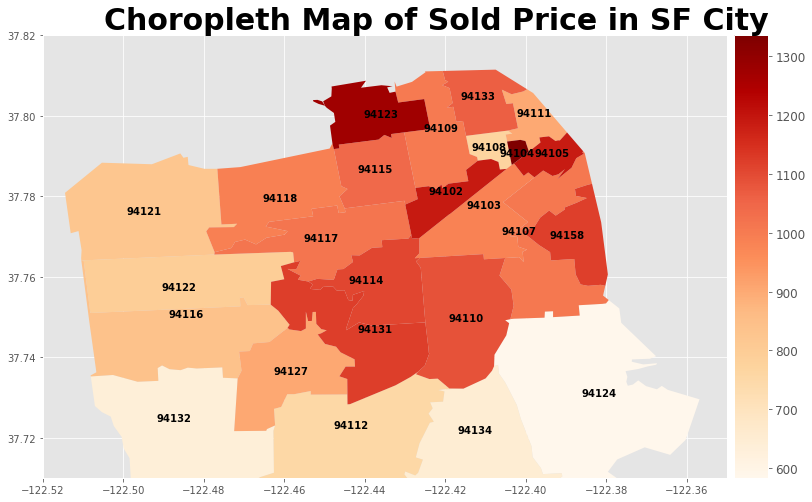

In [33]:
# Visualization

# Size
fig, ax = plt.subplots(1, 1, figsize = (13, 13))
#ax = Geo_df.plot(column = "MedianSoldPricePerSqft_AllHomes", cmap = "OrRd", figsize = (14, 14))

# Set x and y limits to adjust the "zoom".
ax.set_xlim([-122.52, -122.35])
ax.set_ylim([37.71, 37.82])

# Given a row, this function gets a point and plots the sting at that point.
def add_label(row):
    coords = row.geometry.representative_point().coords[0]
    ax.annotate(row.RegionName, xy = coords, horizontalalignment = "center", fontsize=10, fontweight="bold")
    
# Call add_label() on each row.
Geo_df.apply(add_label, axis = 1)


#Adjust the legend size
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

Geo_df.plot(column = 'MedianSoldPricePerSqft_AllHomes', ax = ax, legend = True, cax = cax, cmap = "OrRd")


# labeling
plt.title("Choropleth Map of Sold Price in SF City", fontsize=30, fontweight="bold", loc='right')
plt.xlabel("", fontsize=12)
plt.ylabel("", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.show() 
# Don't print out the result from the .apply().

####  Report: Which parts of the city are the most and least expensive?
1. The color of each shape is based on the value of an associated median sold price per square feet. The darker the color is, the more expensive the area is. The most recent median sold price of that area is chosen to be analyzed. The range of the median sold price is from 1336.12 to 583.53 dollars. 

2. The zip code - 94104 is the most expensive area, which is the financial district of San Francisco. Its median sold price per square feet is 1336.12 dollars, according to the most recent record on 2007-10-01.

3. In contrast, the zip code -94124, including Bayview, Hunters Point, India Basin, Islais Creek, and Silver Terrace district is the least expensive area. Its median sold price per square feet is 583.53 dollars, according to the most recent record on 2016-05-01.

4. The choropleth map shows that northeast areas tend to be more expensive than south areas in San Francisco.


## 2.2  Which parts of the city are the most dangerous (and at what times)?

In [12]:
crime = pd.read_sql_query("""select * from crime""",sf_conn)
crime['Datetime'] = pd.to_datetime(crime['Datetime'])
crime.head(3)

,IncidntNum,Category,Descript,DayOfWeek,Datetime,PdDistrict,Resolution,Address,Lon,Lat
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,2015-01-19 14:00:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.421582,37.761701
1,150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191
2,150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191


In [13]:
CrimeCount = crime.groupby(['PdDistrict'])['IncidntNum'].count() 
CrimeCount = pd.DataFrame ( CrimeCount)
CrimeCount['PdDistrict'] = CrimeCount.index
CrimeCount.columns = ['Crime_Count', 'Area']
CrimeCount.reset_index( drop = True, inplace = True)
CrimeCount.sort_values(by= ['Crime_Count'], ascending=False, inplace = True)
CrimeCount

,Crime_Count,Area
7,196178,SOUTHERN
3,136216,MISSION
4,124365,NORTHERN
1,109242,CENTRAL
0,101655,BAYVIEW
2,89044,INGLESIDE
9,84009,TENDERLOIN
8,75459,TARAVAL
5,60974,PARK
6,56258,RICHMOND


#### Note: SOUTHERN area has highest crime number.

#### Visualization

In [ ]:
# Size
f, ax1 = plt.subplots(1, 1, figsize=(8, 6), sharex=True)

# Color
pal =sns.color_palette("Reds_d", n_colors=10)

# Seaborn
sns.barplot( x='Area' , y='Crime_Count', data = CrimeCount, palette=pal,ax=ax1)

# Label
plt.title('Crime Count by Area',fontsize=20 )
plt.xticks(fontsize=10 , fontweight="bold")
plt.yticks(fontsize=15 , fontweight="bold")
plt.xlabel("Area Name", fontsize=20, fontweight="bold")
plt.ylabel("Crime Count ", fontsize=20, fontweight="bold")
plt.xticks(rotation=90, fontsize=15)

plt.show()

#### To dig more into crime time at SOUTHERN area

In [ ]:
# subset the SOUTHERN
SOUTHERN = crime[ crime['PdDistrict'] == 'SOUTHERN' ]

In [ ]:
# Most dangerous time at SOUTHERN
CrimeTime = SOUTHERN.groupby(  [SOUTHERN['Datetime'].map(lambda t: t.hour)] ).count()
CrimeTime.insert(0,'Hour',CrimeTime.index)
CrimeTime= CrimeTime[['Hour','IncidntNum']].reset_index(drop= True)
CrimeTime.columns=['Hour','CrimeCount']
# CrimeTime

#### Visaulization

In [ ]:
# Size
f, ax1 = plt.subplots(1, 1, figsize=(15, 6), sharex=True)

# Color
pal =sns.color_palette("GnBu_d", n_colors=24)

# Seaborn
sns.barplot( x='Hour' , y='CrimeCount', data = CrimeTime, palette="GnBu_d",ax=ax1)

# Label
plt.title('Crime Count by Area',fontsize=20 )
plt.xticks(fontsize=15 , fontweight="bold")
plt.yticks(fontsize=15 , fontweight="bold")
plt.xlabel("Hours", fontsize=20, fontweight="bold")
plt.ylabel("Crime Count ", fontsize=20, fontweight="bold")
#plt.xticks(rotation=90, fontsize=15)

plt.show()

#### The most common types of the crime happens in SOUTHERN during the noon , and evening (17pm and 19pm ) and midnihjt.

In [ ]:
Crime_type_time = pd.read_sql(
    """
    Select Category,
           Datetime, 
           PdDistrict,
           count(Category) as Count
              
    From crime
    WHERE PdDistrict = 'SOUTHERN' 
          and ( strftime('%H',Datetime) in ('12', '17', '18', '19', '0') )
          and Category != 'NON-CRIMINAL' 
          and Category != 'OTHER OFFENSES'
    group by Category
    order by Count DESC
    """,sf_conn)

Crime_type_time.head()

#### Report: 1.2.2 Which parts of the city are the most dangerous (and at what times)?
1. Based on the crime data from Jan. 2015 to Aug. 2016, SOUTHERN has the highest number of crime as 196178. Areas with the second and thrid highest number of crimes are MISSION and NORTHERN, respectively, as shown in the histogram of "Crime Count v.s. Area". 

2. In the SOUTHERN area, most of the crime happens during 18:00 to 19:00. Also, the number of crime peaks at 12:00, as shown in the histogram of "Crime Count v.s. The hour in the Southern area". 

3. During the most dangerous time (noon and evening from 17 to 19 pm), the top three common categories of crime are"LARCENY/THEFT", "ASSAULT", and "WARRANTS".

4. Finally, this brief report suggests that residents who live in the southern area need to be vigilant for LARCENY/THEFT during the most dangerous times, such as noon and evening(17-19 pm).

<pre>

</pre>

## 2.3 Are noise complaints and mobile food vendors related?

In [ ]:
noise = pd.read_sql_query("""select * from noise""",sf_conn)
noise.head()
#noise.shape

In [ ]:
# Chekc how many noise cause by mobile_food_facility
noise_type = pd.read_sql("""select Type, Datetime, count(Type) as count 
                            from noise
                            where Type = 'mobile_food_facility'
                            group by Type
                         """,sf_conn)

noise_type

In [ ]:
# When are noise compliants the most
noise_time = pd.read_sql("""select CaseID, Datetime , 
                            strftime("%H",Datetime) as Hour,
                            count(CaseID) as count
                            
                            from noise
                            group by Hour 
                            order by count DESC
                            """,sf_conn)
# noise_time.head(3)

In [ ]:
#plot
f, ax1 = plt.subplots(1, 1, figsize=(15, 6), sharex=True)

#sns.barplot( Rank.loc[:,'food'] , Rank.loc[:,'Best_Combination'], palette="GnBu_d")
sns.barplot( x='Hour' , y='count', data = noise_time, palette="Greens_d",ax=ax1)


# Label
plt.title('Noise by Hour',fontsize=20 ,fontweight ='bold')
plt.xticks(fontsize=15 ,fontweight ='bold')
plt.yticks(fontsize=15,fontweight ='bold')
plt.xlabel("Hour", fontsize=20, fontweight ='bold')
plt.ylabel("Noise Count ", fontsize=20, fontweight ='bold')

plt.show()

 #### Geovisualization

In [ ]:
# Convert Noise to a GeoPanda DataFrame
Inglat = [ geom.Point (x) for x in zip (noise.Lon, noise.Lat)]
Noise_Geo = gpd.GeoDataFrame(noise, geometry = Inglat)

# Subset Noise from mobile_food_facility only
MobilFood_Noise_Geo = Noise_Geo.loc [Noise_Geo.Type == 'mobile_food_facility']

In [ ]:
# Convert food locaitons to a GeoPanda DataFrame
FoodLoc = pd.read_sql_query("""select * from mobile_food_locations""",sf_conn)
Inglat = [ geom.Point (x) for x in zip (FoodLoc.Longitude, FoodLoc.Latitude)]
Food_Loc_Geo = gpd.GeoDataFrame(FoodLoc, geometry = Inglat)

In [ ]:
# SF shape
SF_shape = gpd.read_file("C:/Users/WeiKuang/Documents/GitHub/data/SF_zip/geo_export_b8d0ed93-730c-44ae-8d05-66a86114a164.shp")

In [ ]:
# Plotting

# Layer of Fundation
ax = SF_shape.plot(color ="white" , edgecolor ="gray" , figsize = (10, 10))

# Additional Layers
Noise_Geo.plot(ax= ax, color= "black", markersize=10, label="Noise complaints")
MobilFood_Noise_Geo.plot(ax = ax, color ='red', markersize=35, label="Noise of mobile food facility" )
Food_Loc_Geo.plot(ax= ax, color= 'blue', markersize=10, label="Food vendors")

# label and legend
plt.legend(loc=2, fontsize = 'x-large')
plt.title('Location of Noise Complaints and Food Vendor',fontsize=20 ,fontweight ='bold')

# Size setting
ax.set_xlim([-122.52, -122.35])
ax.set_ylim([37.71, 37.84])

#### Ans to "Are noise complaints and mobile food vendors related?"
1. The black dots are noise complaints. Yellow dots are noise complaints caused by mobile food facility. Green dots are the location of all kinds of food vendors. 
2. Food vendors mostly located on business area and main streets, and noise complaints seem to locate on non-business areas. 
3. Second, a small number of noise complaints are caused by "mobile_food_facility". There are only seven noise complaints about mobile_food_facility, comparing to 4795 ( the total noise complaints).
4. Third, my investigation in times of noise shows that most of the noise complaints occurred between 22 and 23 pm in which fewer food vendors operate their business. 
5. Thus, the relationship between noise complaints and food vendors seems to be very weak.

<pre>

</pre>

## 2.4 My curiosity: What are the times in which most food vendors are avaliable?

In [ ]:
# Get the approved permit
permits = pd.read_sql(""" select * from mobile_food_permits
                          where Status = 'APPROVED' """,sf_conn)

In [ ]:
# Get the list of approved Food Truck
Truck_permits = pd.read_sql(""" select * from mobile_food_permits
                                where Status = 'APPROVED' and FacilityType = 'Truck' """,sf_conn)
Truck_permits = Truck_permits.permit
Truck_permits = Truck_permits.unique().tolist()

In [ ]:
# Subset
schedule=pd.read_sql_query("select * FROM mobile_food_schedule",sf_conn)
Truck_hour = schedule[ schedule.permit.isin(Truck_permits) ] 

In [ ]:
Truck_hour = Truck_hour.reset_index(drop= True)
#Truck_hour.head()
Truck_hour.shape

In [ ]:
# Creat a list reflect the business hours for each food truck
H=[]
n,p = Truck_hour.shape

for i in range(n) :
    if  Truck_hour['StartHour'][i] < Truck_hour['EndHour'][i]:
        H= H + [np.linspace(Truck_hour['StartHour'][i], Truck_hour['EndHour'][i], Truck_hour['EndHour'][i] - Truck_hour['StartHour'][i]+1)]
    else :
        T1 = np.linspace(Truck_hour['StartHour'][i], 23, 23- Truck_hour['StartHour'][i]+1)
        T2 = np.linspace(0,Truck_hour['EndHour'][i], Truck_hour['EndHour'][i]+1)
        T3 = np.concatenate((T1, T2), axis=0)
        H= H + [T3] 
        
H[0:3]

In [ ]:
# Creat an initial Dataframe
d= {'0_Hour': [x for x in range(24)], '1_Count': [x for x in range(24)]}
DF= pd.DataFrame(data=d)

In [ ]:
# For loop
n,p = Truck_hour.shape
for h in range(0,24):         # h iterates through 0 to 23 hr
    count=0
    for i in range(n):        # check if "h" in the business hour
        if h in H[i]:
            count = count+1
            
        DF.iloc[h,0] = h      # assign value to hour
        DF.iloc[h,1] = count  # assign value to count

In [ ]:
#plot
f, ax1 = plt.subplots(1, 1, figsize=(14, 6), sharex=True)

sns.barplot( x='0_Hour' , y='1_Count', data = DF, palette="GnBu_d",ax=ax1)


# Label
plt.title('Count of Food Truck vs Business Hour in San Francisco',fontsize=20, fontweight ='bold')
plt.xticks(fontsize=15, fontweight ='bold')
plt.yticks(fontsize=15, fontweight ='bold')
plt.xlabel("Hour", fontsize=15, fontweight ='bold')
plt.ylabel(" Count of Food Trucks ", fontsize=15, fontweight ='bold')

plt.show()

#### ANS to "What are the times in which most food vendors are avaliable?"
1. First, the approved food trucks were selected from the database. 
2. Second, based on StartHour and EndHour, an array of the business hour was created. For example, Business hour 9-13 is denoted as [9,10,11,12,13]
3. Then, I use for loop to count the number of hours appear in the business hours.
4. The result reveals that most food trucks are available during 10 and 11 am in general. Thus, this period might be the best time to find food trucks.

<pre>

</pre>

## 2.5 My curiosity:  Are Elementary schools in the safe area (that is, the area has lower crime count) ?

In [ ]:
# Convert School to a GeoPanda Data Frame
schools = pd.read_sql_query("""select * from schools""",sf_conn)
Inglat_sch = [ geom.Point (x) for x in zip (schools.Lon, schools.Lat)]
Schools_Geo = gpd.GeoDataFrame(schools, geometry = Inglat_sch)

In [ ]:
# Subset Elementary school
Ele_Sch_Geo = Schools_Geo [Schools_Geo.Name.str.contains('Elementary') ]

In [ ]:
#Convert Crime to a GeoPanda Frame
Inglat_crime = [ geom.Point (x) for x in zip (crime.Lon, crime.Lat)]
Crime_Geo = gpd.GeoDataFrame(crime, geometry = Inglat_crime)

In [ ]:
# Select the crime related to the safety of children 
crime_time = pd.read_sql("""select * from crime
                            WHERE strftime('%H',Datetime) between '10' and '18'
                            and Category = 'SEX OFFENSES, FORCIBLE'
                            or Category = 'SEX OFFENSES, NON FORCIBLE'
                            or Category = 'KIDNAPPING'
                            or Category = 'WEAPON LAWS'
                        """,sf_conn)

In [ ]:
# Convert Crime to a GeoPanda Frame
Inglat_crime_time = [ geom.Point (x) for x in zip (crime_time.Lon, crime_time.Lat)]
Crime_Time_Geo = gpd.GeoDataFrame(crime_time, geometry = Inglat_crime_time)

In [ ]:
# Subset the type of crime
Sex_Crime = Crime_Time_Geo[ Crime_Time_Geo.Category.isin( ['SEX OFFENSES, FORCIBLE','SEX OFFENSES, NON FORCIBLE' ] ) ]
KIDNAPPING_Crime = Crime_Time_Geo[ Crime_Time_Geo.Category.isin( ['KIDNAPPING'] ) ]
WEAPON_LAWS_Crime = Crime_Time_Geo[ Crime_Time_Geo.Category.isin( ['WEAPON LAWS'] ) ]

In [ ]:
# Plot
# Back ground
ax = SF_shape.plot(color ="gray" , edgecolor ="white" , figsize = (15, 15))

# Foundation layer
Sex_Crime.plot(ax= ax, color= 'pink', markersize=10, label= 'Sex Crime', alpha=1)
# Additional layers
Ele_Sch_Geo.plot(ax= ax, color= "blue", markersize=30, label = 'Elementary School')
WEAPON_LAWS_Crime.plot(ax= ax, color= 'yellow', markersize=10, label= 'WEAPON_LAWS Crime')
KIDNAPPING_Crime.plot(ax= ax, color= 'red', markersize=10, label= 'KIDNAPPING Crime', alpha=1)

# Label
plt.title('Location of Crime Complaints and Elementary schools',fontsize=20 ,fontweight ='bold')
plt.legend(loc=2, fontsize = 'x-large')
ax.set_xlim([-122.52, -122.35])
ax.set_ylim([37.71, 37.84])

In [ ]:
ax = SF_shape.plot(color ="lightgray" , edgecolor ="black" , figsize = (10, 10))
Sex_Crime.plot(ax= ax, color= 'pink', markersize=10, label= 'Sex Crime')
Ele_Sch_Geo.plot(ax= ax, color= "blue", markersize=30, label = 'Elementary School')


# Label
plt.title('Location of Sex Crime and Elementary schools',fontsize=20 ,fontweight ='bold')
plt.legend(loc=2, fontsize = 'x-large')
ax.set_xlim([-122.52, -122.35])
ax.set_ylim([37.71, 37.84])

In [ ]:
ax = SF_shape.plot(color ="lightgray" , edgecolor ="black" , figsize = (10, 10))
KIDNAPPING_Crime.plot(ax= ax, color= 'red', markersize=10, label= 'KIDNAPPING Crime', alpha=1)
Ele_Sch_Geo.plot(ax= ax, color= "blue", markersize=30, label = 'Elementary School')


# Label
plt.title('Location of KIDNAPPING and Elementary schools',fontsize=20 ,fontweight ='bold')
plt.legend(loc=2, fontsize = 'x-large')
ax.set_xlim([-122.52, -122.35])
ax.set_ylim([37.71, 37.84])

In [ ]:
ax = SF_shape.plot(color ="lightgray" , edgecolor ="black" , figsize = (10, 10))
WEAPON_LAWS_Crime.plot(ax= ax, color= 'yellow', markersize=10, label= 'WEAPON_LAWS Crime', alpha=1)
Ele_Sch_Geo.plot(ax= ax, color= "blue", markersize=30, label = 'Elementary School')

# Label
plt.title('Location of Weapon law crime and Elementary schools',fontsize=20 ,fontweight ='bold')
plt.legend(loc=2, fontsize = 'x-large')
ax.set_xlim([-122.52, -122.35])
ax.set_ylim([37.71, 37.84])

#### ANS to "Are the elementary schools in the safe area (that is, the area has lower crime count) ?"
1. The crimes related to sex offenses (pink), kidnapping (red), and weapon laws(yellow) at 10 am -18 pm were selected be investigated. I guess many children might be active around the school during this window of time.
2. The map showed that most of these crimes occurred at SF's financial district, Mission, and Bayview areas.
3. Among the three types of crimes, the number of weapon laws crimes are the most.
4. It seems that these crimes had the chance to occur nearby most of the elementary schools.
5. My research reveals that elementary schools in central areas of SF were relatively safer.